# calculate events from Observational records of climate modes

In [1]:
_work_dir='/g/data/gv90/as2285/compound/'
import sys
sys.path.append(_work_dir)

In [2]:
import xarray
import pandas

#stuff to help with plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [5]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run {_work_dir}helpers/impactPlots.ipynb

In [6]:
nino3Domain=_index.sstIndex['nino3']

nino3Domain

{'latMin': -5, 'latMax': 5, 'longMin': 210, 'longMax': 270}

In [7]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino3Box={
    'xy':[nino3Domain['longMin']-mapCentre, nino3Domain['latMin']],
    'width':nino3Domain['longMax']-nino3Domain['longMin'],
    'height':nino3Domain['latMax']-nino3Domain['latMin']
}

nino3Box

{'xy': [0, -5], 'width': 60, 'height': 10}

In [8]:
nino4Domain=_index.sstIndex['nino4']

#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino4Box={
    'xy':[nino4Domain['longMin']-mapCentre, nino4Domain['latMin']],
    'width':nino4Domain['longMax']-nino4Domain['longMin'],
    'height':nino4Domain['latMax']-nino4Domain['latMin']
}

nino4Box

{'xy': [-50, -5], 'width': 50, 'height': 10}

# Load the sst dataset

In [67]:
paths = !find {_work_dir}ref/ersst/*.nc

In [ ]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [73]:
sstXr

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 792)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1957-01-16 00:00:00 ... 2022-12-16 00:00:00
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... -1.8 -1.8 -1.8 -1.8
    ssta     (time, lat, lon) float32 nan nan nan ... -4.768e-07 -4.768e-07
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.195701
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [ ]:
sstClimat=sst.calculateClimatology(
    sstXr.sst.where(
        (sstXr.time.dt.year>=1971)
        *(sstXr.time.dt.year<=2000)
    )
)

In [ ]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [ ]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [11]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables:
    nino3                   (year) float64 0.9921 -0.0506 ... -0.3786 -0.947
    westIONoDetrend         (year) float64 -0.3825 -0.3005 ... 0.9758 0.5053
    dmi                     (year) float64 -0.2179 -0.6161 ... 1.481 0.05624
    westIO                  (year) float64 -0.3615 -0.1887 ... 0.4602 0.1715
    eastIONoDetrend         (year) float64 -0.1646 0.3155 ... -0.5053 0.4491
    nino4                   (year) float64 0.4964 0.3311 ... 0.5096 -0.6466
    nino34NoDetrend         (year) float64 1.238 0.2379 ... 0.538 -0.7718
    backgroundSstNoDetrend  (year) float64 0.05152 -0.08729 ... 0.5706 0.2591
    eastIO                  (year) float64 -0.1437 0.4273 ... -1.021 0.1153
    nino4NoDetrend          (year) float64 0.5479 0.2438 ... 1.08 -0.3876
    nino34                  (year) float64 1.187 0.3252 ... -0.03262 -1.031

<<<<<<< local <modified: text/plain>


>>>>>>> remote <modified: text/plain>


<<<<<<< local


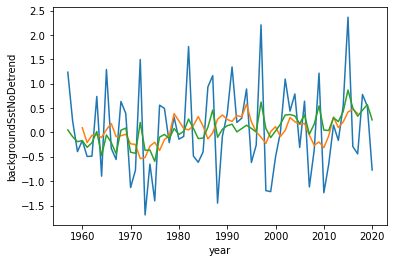

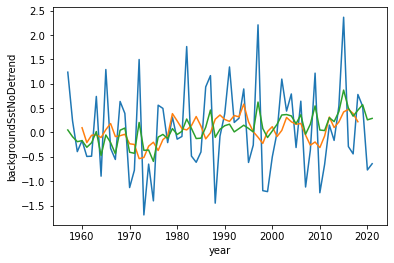

>>>>>>> remote


In [ ]:
indexXr.nino34NoDetrend.plot()
indexXr.nino34NoDetrend.rolling(year=7,center=True).mean('year').plot()
indexXr.backgroundSstNoDetrend.plot()

In [ ]:
varsToDetrend=[
    'dmi',
    'eastIO',
    'nino34',
    'westIO',
    'nino4',
    #'samWinter',
    #'samSummer'
]

In [ ]:
#detrend
indexXr['dmiNoDetrend']=indexXr.dmi
            
for iVar in varsToDetrend:
    indexXr[iVar+'RollingDetrend']=(
        indexXr[iVar+'NoDetrend']
        -indexXr[iVar+'NoDetrend'].rolling(
            year=11,min_periods=5,center=True
        ).mean('year')
    )




In [ ]:
# and EC index too
sstAnoms=ec.sstAnoms(
    sstXr.sst, 
    sstXr.sst.where(
        (sstXr.time.dt.year>=1971)
        *(sstXr.time.dt.year<=2000)
    )
)

sstAnoms.load()

#create the solver
solver=ec.eofSolver(
    sstAnoms.where(
        (sstAnoms.time.dt.year>=1971)
        *(sstAnoms.time.dt.year<=2000), 
        drop=True
    )
)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

In [ ]:
std=pcXr.std()

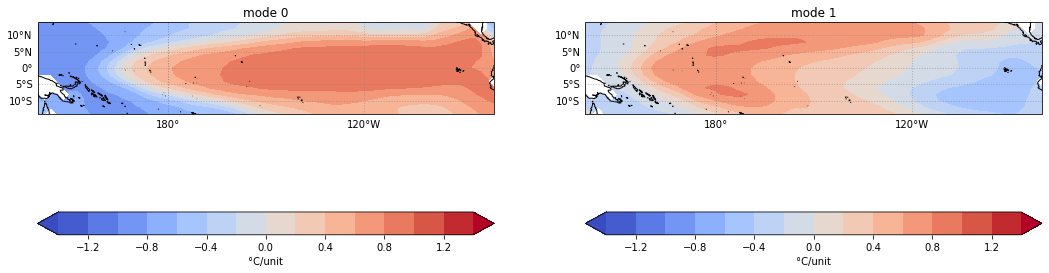

In [ ]:
multiplyBy=[1,1]

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=mapCentre))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

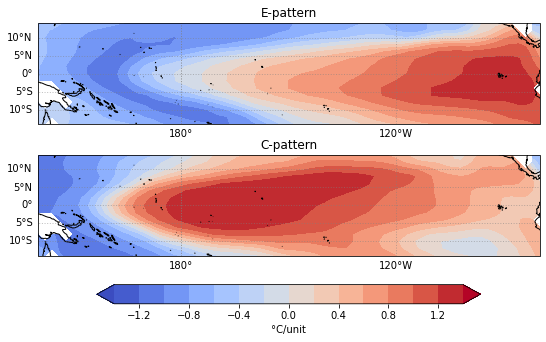

In [ ]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(2,1,1,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax, colorbar=False)
ax.add_patch(mpatches.Rectangle(
                xy=nino3Box['xy'], 
                width=nino3Box['width'], 
                height=nino3Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))

plt.draw()
plt.title("E-pattern")

ax=fig.add_subplot(2,1,2,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
ax.add_patch(mpatches.Rectangle(
                xy=nino4Box['xy'], 
                width=nino4Box['width'], 
                height=nino4Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
plt.title("C-pattern")
plt.subplots_adjust(hspace=-0.3)
# plt.savefig('figures/obsEvsCPattern.pdf')
plt.show()


In [ ]:
fieldXr=solver.projectField(sstAnoms, neofs=2)

In [ ]:
pcXr=xarray.Dataset()

In [ ]:
pcXr['pc1']=fieldXr.sel(mode=0)
pcXr['pc2']=fieldXr.sel(mode=1)
pcXr=pcXr/std

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

In [ ]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

<<<<<<< local


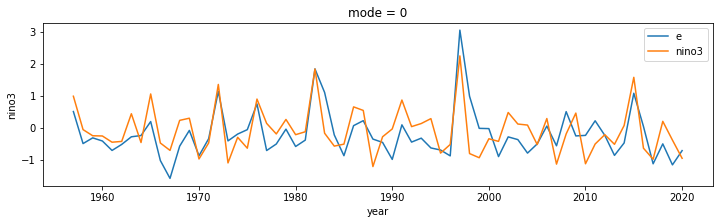

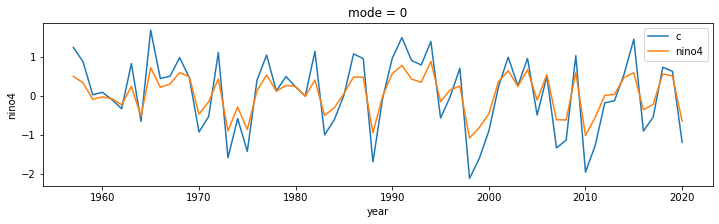

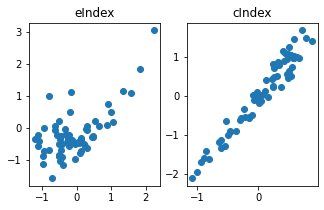

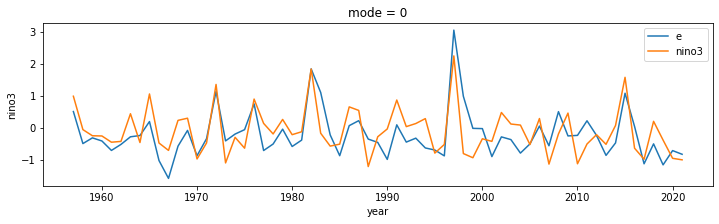

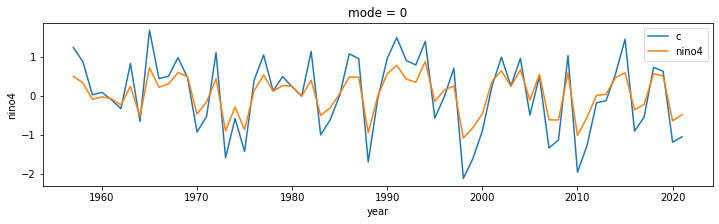

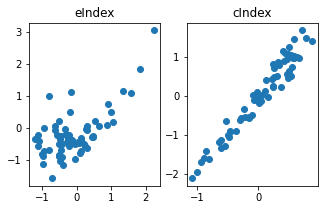

>>>>>>> remote


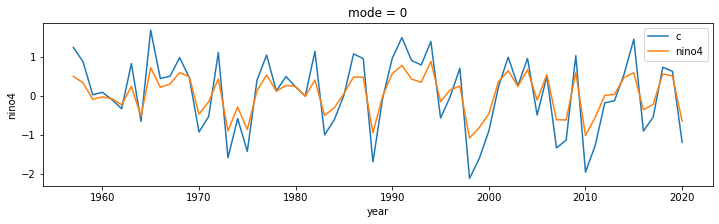

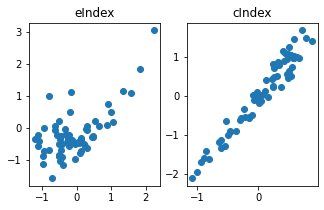

In [ ]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.nino3.plot()
plt.legend(['e','nino3'])


#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.cIndex.plot()
indexXr.nino4.plot()

#plt.xlim([1950,2050])
plt.legend(['c','nino4'])

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino3, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino4, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [30]:
marshallPd=pandas.read_csv(
    f'{_work_dir}ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [31]:
marshallPd

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
1957,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78
2020,0.57,-0.36,2.05,-1.72,1.03,1.18,-0.97,-2.20,-0.25,1.79,1.14,2.28
2021,1.95,2.19,-0.95,0.87,0.75,1.88,-1.06,0.73,1.68,0.80,2.69,2.74


In [32]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [87]:
indexXr['samSummer']=xarray.DataArray(
    (
        marshallXr.sel(
            year=range(1957,2022),
            month=['OCT','NOV','DEC']
        ).sum('month').values  #This is the sep to dec sum for each year
        + marshallXr.sel(
            year=range(1958,2023),
            month=['JAN','FEB','MAR']
        ).sum('month').values   #This is the jan feb sum for the next year
    )/6, 
    {'year':marshallXr.year.values[0:-1]}, 
    dims='year'
)

In [88]:
indexXr['samWinter']=(
     marshallXr.sel(
        year=range(1957,2022),
        month=['APR','MAY','JUN','JUL','AUG','SEP']
    ).sum('month')
)/6

In [89]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 65)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2019 2020 2021
    mode                    int64 0
Data variables: (12/21)
    eastIONoDetrend         (year) float64 -0.1646 0.3155 ... 0.4491 0.6608
    nino34                  (year) float64 1.187 0.3252 ... -1.029 -0.931
    backgroundSstNoDetrend  (year) float64 0.05152 -0.08729 ... 0.2594 0.2892
    eastIO                  (year) float64 -0.1437 0.4273 ... 0.1153 0.3469
    nino4                   (year) float64 0.4964 0.3311 ... -0.64 -0.4846
    nino3                   (year) float64 0.9921 -0.0506 ... -0.9475 -0.9949
    ...                      ...
    westIORollingDetrend    (year) float64 -0.0632 -0.0215 ... -0.1681 -0.178
    nino4RollingDetrend     (year) float64 0.6324 0.2792 ... -0.8432 -0.492
    cIndex                  (year) float64 1.236 0.8704 ... -1.187 -1.049
    eIndex                  (year) float64 0.5134 -0.4873 ... -0.7064 -0.8214
    samSummer               (year) float64 -2.748 0.3033 1.265 ... 1.4 1.937
    samWinter               (year) float64 -0.8917 -0.4617 ... -0.4883 0.8083

In [90]:
#save them for use elsewhere

indexXr.to_netcdf(f'{_work_dir}/results/obsIndeces.nc')

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1970-2000 (somewhat arbitrary?)

In [6]:
indexXr=xarray.open_dataset('results/obsIndeces.nc')

In [91]:
stdXr=indexXr.sel(year=slice(1971,2000)).std()

In [92]:
criteriaXr=stdXr[['dmi','nino3','nino34','nino4', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samWinter']=stdXr.samWinter/2
criteriaXr['samSummer']=stdXr.samSummer/2

In [93]:
criteriaXr

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    mode       int64 0
Data variables:
    dmi        float64 0.4346
    nino3      float64 0.8052
    nino34     float64 0.8016
    nino4      float64 0.5265
    eastIO     float64 0.3975
    eIndex     float64 0.8651
    cIndex     float64 1.012
    samWinter  float64 0.452
    samSummer  float64 0.4833

In [94]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['nino34', 'samWinter', 'eIndex', 'nino4', 'nino3', 'dmi', 'cIndex']
fireNeg: 
['samSummer', 'eastIO']


In [95]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [96]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [97]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 65)
Coordinates:
  * year        (year) int64 1957 1958 1959 1960 1961 ... 2018 2019 2020 2021
    mode        int64 0
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    nino34      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 1.0
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    eIndex      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 0.0 0.0
    nino4       (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    nino3       (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0 1.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    cIndex      (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 1.0
    samSummer   (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 1.0 1.0
    eastIO      (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    ecCombined  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 1.0 1.0

In [98]:
eventsXr.to_netcdf(f'{_work_dir}results/obsEvents.nc')

In [117]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.year.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).values
    
    print(str(iEvent) + ' : ' + str(years))

nino34 : [1957. 1965. 1972. 1982. 1986. 1991. 1997. 2015.]
samWinter : [1967. 1976. 1979. 1982. 1985. 1989. 1993. 1997. 1998. 1999. 2001. 2003.
 2004. 2005. 2008. 2010. 2012. 2015. 2016. 2017. 2021.]
eIndex : [1972. 1982. 1983. 1997. 1998. 2015.]
nino4 : [1965. 1968. 1977. 1990. 1991. 1994. 2002. 2004. 2006. 2009. 2015. 2018.]
nino3 : [1957. 1965. 1972. 1976. 1982. 1991. 1997. 2015.]
dmi : [1961. 1963. 1967. 1972. 1994. 1997. 2006. 2012. 2015. 2018. 2019.]
cIndex : [1957. 1965. 1972. 1977. 1982. 1986. 1991. 1994. 2009. 2015.]
samSummer : [1957. 1964. 1965. 1966. 1967. 1968. 1971. 1974. 1976. 1979. 1982. 1984.
 1986. 1991. 2000. 2002. 2016. 2019.]
eastIO : [1961. 1963. 1967. 1972. 1994. 1997. 2006. 2019.]
ecCombined : [1957. 1965. 1972. 1977. 1982. 1983. 1986. 1991. 1994. 1997. 1998. 2009.
 2015.]


Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (ok, not great)


In [118]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.year.where(
        eventsXr[iEvent].sel(fire='neg')==True, 
        drop=True
    ).values
    
    print(str(iEvent) + ' : ' + str(years))

nino34 : [1973. 1975. 1988. 1998. 1999. 2007. 2010. 2020. 2021.]
samWinter : [1957. 1958. 1963. 1964. 1968. 1971. 1972. 1974. 1975. 1977. 1980. 1981.
 1988. 1990. 1991. 1992. 1994. 1996. 2007. 2009. 2013. 2020.]
eIndex : [1966. 1967. 1970. 1985. 1990. 1996. 2001. 2017. 2019.]
nino4 : [1964. 1973. 1975. 1988. 1998. 1999. 2007. 2008. 2010. 2011. 2020.]
nino3 : [1970. 1973. 1988. 1999. 2007. 2010. 2017. 2020. 2021.]
dmi : [1958. 1960. 1981. 1990. 1992. 1996. 1998. 2005. 2010. 2016.]
cIndex : [1973. 1975. 1988. 1998. 1999. 2007. 2008. 2010. 2011. 2020. 2021.]
samSummer : [1959. 1961. 1962. 1973. 1981. 1983. 1989. 1993. 1996. 1998. 1999. 2001.
 2006. 2007. 2008. 2010. 2011. 2012. 2014. 2015. 2017. 2018. 2020. 2021.]
eastIO : [1958. 1960. 1975. 1988. 1992. 1998. 2005. 2010. 2016.]
ecCombined : [1966. 1967. 1970. 1973. 1975. 1985. 1988. 1990. 1996. 1998. 1999. 2001.
 2007. 2008. 2010. 2011. 2017. 2019. 2020. 2021.]


# Check events against the initial SSTs:

In [119]:
ensoSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='nino34'))
iodSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='dmi'))

In [121]:
%run {_work_dir}helpers/impactPlots.ipynb

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>,
 <Axes:xlabel='_nolabel_'>]

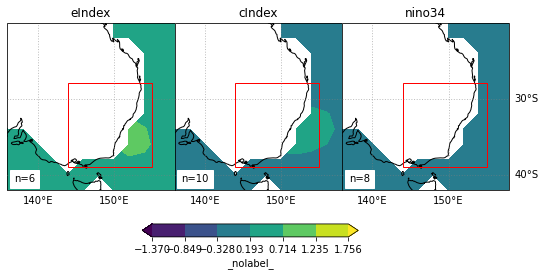

In [122]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

[<GeoAxesSubplot:title={'center':'eIndex'}>,
 <GeoAxesSubplot:title={'center':'cIndex'}>,
 <GeoAxesSubplot:title={'center':'nino34'}>,
 <Axes:xlabel='_nolabel_'>]

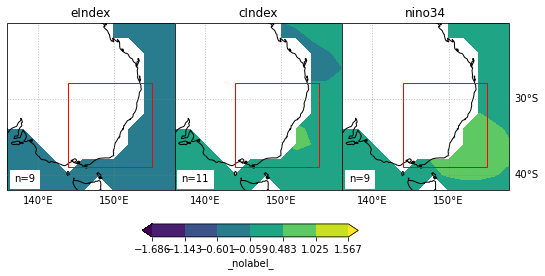

In [123]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

[<GeoAxesSubplot:title={'center':'dmi'}>, <Axes:xlabel='_nolabel_'>]

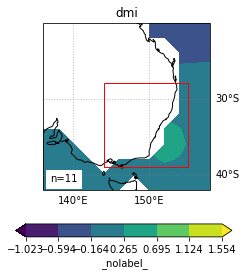

In [124]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)

[<GeoAxesSubplot:title={'center':'dmi'}>, <Axes:xlabel='_nolabel_'>]

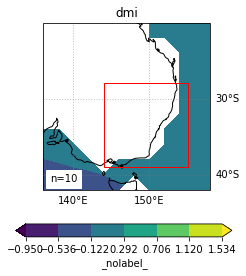

In [125]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)